# Analyse Reference catalog

 work with Weakly_2024_07
- use jupyter kernel LSST


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab
- creation date : 2024/03/04
- update : 2024/03/04


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm


import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import math
import lsst.geom

In [3]:
ls ../data/202402

Analyse_isolated_star_sources.ipynb
atlas_refcat2_20220201_202402.csv
AUXTEL_DRP_IMAGING_20230509_20240201-ListOfExposures.csv
ccdVisitTable_202402.csv
finalized_src_table_202402.csv
gaia_dr3_20230707_202402.csv
icSrc_202402.csv
isolated_star_cat_202402-Copy1.csv
isolated_star_cat_202402.csv
isolated_star_sources_202402-Copy1.csv
isolated_star_sources_202402.csv
Latiss_tractspatchs_202402.pickle
Latiss_tractspatchs_radec_202402.pickle
Latiss_tractspatchs_radec_htm7_skypixels_202402-Copy1.pickle
Latiss_tractspatchs_radec_htm7_skypixels_202402.pickle
Latiss_tractspatchs_radec_radians_202402.pickle
objectTable_202402.csv
preSourceTable_202402.csv
preSourceTablevisit_202402.csv
SelectedVisits_fall2023_tract_3864.csv
sourceTable_visit_202402_20231121-20231222.csv
sourceTable_visit_202402.csv
src_202402.csv
SrcTable_202402.csv


In [4]:
filesource_in="../data/202402/atlas_refcat2_20220201_202402.csv"

In [5]:
# Load data (deserialize)
import pickle
#with open('Latiss_tractspatchs.pickle', 'rb') as handle:
with open('../data/202402/Latiss_tractspatchs_radec_htm7_skypixels_202402.pickle', 'rb') as handle:
    tracts_patchs_dict = pickle.load(handle)

In [6]:
tracts_patchs_dict

{382: {'htmpixels': array([135892, 135895]),
  'radec': array([ 11.83559184,  12.69437584, -72.91970512, -72.82704592])},
 383: {'htmpixels': array([135892, 135895]),
  'radec': array([ 12.30552976,  12.88215539, -72.91694386, -72.82704468])},
 452: {'htmpixels': array([135696, 135699]),
  'radec': array([  0.69689026,   1.83680741, -72.85580215, -72.60316762])},
 455: {'htmpixels': array([135892, 135894, 135895]),
  'radec': array([ 12.00059065,  12.86592199, -72.93792989, -72.68219831])},
 3863: {'htmpixels': array([162489, 162491]),
  'radec': array([119.93688346, 120.2482689 , -36.32070757, -36.06942145])},
 3864: {'htmpixels': array([162888, 162891]),
  'radec': array([122.28140604, 122.69508293, -36.32124229, -35.98768246])},
 5614: {'htmpixels': array([177672, 177716]),
  'radec': array([238.7893974 , 239.15622802, -24.41986978, -24.16893036])},
 5615: {'htmpixels': array([177675]),
  'radec': array([239.8629916 , 240.13697795, -24.17042533, -23.83709706])},
 5616: {'htmpixels':

In [7]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

# Read input catalog

In [8]:
df = pd.read_csv(filesource_in,index_col=0)

In [9]:
df

,id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,g_fluxErr,r_fluxErr,i_fluxErr,...,pm_ra,pm_dec,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,Ag,skypix
0,20250001146157390,0.002000,-1.276166,10452.024041,50396.502778,1.302566e+05,2.165707e+05,1819.550582,5895.301894,12357.731463,...,1.082104e-07,-1.856836e-08,3.345214e-09,2.278624e-09,False,8.484239e-09,1.454441e-09,False,0.105,135696
1,20250001184196331,0.002067,-1.276181,13601.913229,41114.972110,7.585769e+04,1.037527e+05,1929.401669,4468.728156,7406.403935,...,6.108652e-08,-4.246968e-08,4.363323e-09,3.054326e-09,False,5.720801e-09,1.939255e-09,False,0.107,135696
2,20250003818199141,0.006664,-1.276140,81432.993523,117597.909095,1.328007e+05,1.402167e+05,8325.787224,11265.095252,12476.779522,...,3.160985e-08,4.605730e-09,2.230143e-09,1.405960e-09,False,5.332950e-10,9.211460e-10,False,0.107,135696
3,20260000854748562,0.001492,-1.276003,7112.135137,30422.885295,7.211081e+04,1.140775e+05,1428.099288,3839.042009,6907.734996,...,7.121913e-08,1.619278e-08,4.848137e-09,3.345214e-09,False,3.199770e-09,2.181662e-09,False,0.106,135696
4,20260001535944702,0.002681,-1.276059,188104.679641,360080.497527,4.246196e+05,4.504013e+05,8143.280009,14924.990454,8995.592319,...,-1.978040e-08,-2.933123e-08,1.066590e-09,7.272206e-10,False,2.375587e-09,4.848137e-10,False,0.110,135696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,116233079445224336,5.374646,0.119757,32960.971218,56078.966337,6.963064e+04,7.733919e+04,3643.201357,5475.298416,6670.151040,...,-1.658063e-08,-1.546556e-08,3.005845e-09,2.617994e-09,False,3.151289e-09,1.842292e-09,False,0.288,205936
5692,116233079495266290,5.374733,0.119785,386901.131655,946238.032883,1.475027e+06,1.829785e+06,3920.077148,8715.700946,13586.322531,...,3.388848e-08,-8.290314e-09,4.363323e-10,3.393696e-10,False,5.720801e-09,2.908882e-10,False,0.283,205936
5693,116233079506521351,5.374753,0.119713,33542.853083,89701.560841,1.411238e+05,1.747429e+05,741.503441,1074.101397,1429.864929,...,-3.364607e-08,-3.102808e-09,2.181662e-09,1.939255e-09,False,1.599885e-09,1.308997e-09,False,0.282,205936
5694,116233079525239419,5.374785,0.119831,19444.662074,64744.070457,1.953440e+05,3.293060e+05,483.577526,954.161609,1979.222476,...,8.484239e-09,-5.250532e-08,1.890773e-09,1.648367e-09,False,6.254096e-09,1.163553e-09,False,0.275,205936


In [10]:
colnames = list(df.columns)
for name in colnames:
    print(name)

id
coord_ra
coord_dec
g_flux
r_flux
i_flux
z_flux
g_fluxErr
r_fluxErr
i_fluxErr
z_fluxErr
variable
epoch
pm_ra
pm_dec
pm_raErr
pm_decErr
pm_flag
parallax
parallaxErr
parallax_flag
Ag
skypix


In [11]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [12]:
TRACT_SEL = 3864


List_Skypixels_selected = tracts_patchs_dict[TRACT_SEL]['htmpixels']
RAMIN,RAMAX,DECMIN,DECMAX = tracts_patchs_dict[TRACT_SEL]['radec']
NPIX = len(List_Skypixels_selected)

if NPIX>0:
    cut = (df.skypix == List_Skypixels_selected[0])
    
if NPIX == 2:
    cut = cut | (df.skypix == List_Skypixels_selected[1])
    
df = df[cut]

In [13]:
df

,id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,g_fluxErr,r_fluxErr,i_fluxErr,...,pm_ra,pm_dec,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,Ag,skypix
0,63771221514557334,2.131945,-0.643196,2.466039e+04,8.871552e+04,1.855240e+05,2.728980e+05,2589.445532,8498.354989,17259.304969,...,-8.047907e-08,7.063735e-08,3.587621e-09,3.733065e-09,False,-2.327106e-09,2.230143e-09,False,3.183,162888
1,63781221420699882,2.131781,-0.643014,2.021157e+04,5.566733e+04,9.594006e+04,1.260085e+05,3872.266722,7639.916242,11222.914386,...,-2.482246e-08,1.677455e-08,2.424068e-09,2.860401e-09,False,-9.211460e-10,1.745329e-09,False,3.225,162888
2,63781221495327532,2.131912,-0.643048,9.044813e+05,2.006319e+06,3.486583e+06,3.153552e+06,22493.928440,44351.996125,80286.391274,...,-1.473834e-08,9.356904e-09,9.211460e-10,9.211460e-10,False,-1.405960e-09,5.817764e-10,False,3.239,162888
3,63781221496197114,2.131913,-0.643054,8.961906e+05,2.097008e+06,3.644182e+06,3.667752e+06,26415.104578,56014.428825,104055.156985,...,-1.231427e-08,1.464137e-08,5.817764e-10,5.332951e-10,False,-9.696274e-11,2.908882e-10,False,3.234,162888
4,63781221553515747,2.132013,-0.643074,1.356438e+04,3.688077e+04,6.303771e+04,8.241374e+04,2323.886287,4348.224238,6154.718499,...,-1.134464e-08,1.270212e-08,3.490659e-09,4.169398e-09,False,4.217879e-09,2.278624e-09,False,3.213,162888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30754,64791229615094340,2.146083,-0.628405,4.724976e+05,1.099511e+06,1.678031e+06,2.054944e+06,43521.266879,101274.831420,154561.715341,...,1.308997e-09,1.115071e-09,2.908882e-10,3.393696e-10,False,2.811919e-09,1.939255e-10,False,3.993,162891
30755,64791229620069897,2.146092,-0.628324,6.058987e+05,9.727472e+05,1.304968e+06,1.623305e+06,18974.960108,42111.408586,61301.640450,...,-2.487094e-08,-9.129042e-08,3.878510e-10,4.363323e-10,False,4.411805e-09,2.424068e-10,False,4.045,162891
30756,64791229626481175,2.146103,-0.628451,6.309573e+06,9.853715e+06,1.146041e+07,1.212272e+07,63928.514677,99837.710726,116116.681091,...,-3.694280e-08,6.481959e-08,9.696274e-11,1.454441e-10,False,8.193352e-09,4.848137e-11,False,4.088,162891
30757,64791229633826636,2.146116,-0.628371,1.238227e+04,4.254029e+04,8.605973e+04,1.241651e+05,1904.665872,4741.193707,8323.217200,...,-1.052046e-08,2.399828e-08,2.666475e-09,3.393696e-09,False,-1.890773e-09,1.890773e-09,False,3.919,162891


In [14]:
df["ra"] = df["coord_ra"]*180./np.pi
df["dec"] = df["coord_dec"]*180./np.pi

/tmp/ipykernel_6858/450074700.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ra"] = df["coord_ra"]*180./np.pi
/tmp/ipykernel_6858/450074700.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["dec"] = df["coord_dec"]*180./np.pi


In [15]:
df

,id,coord_ra,coord_dec,g_flux,r_flux,i_flux,z_flux,g_fluxErr,r_fluxErr,i_fluxErr,...,pm_raErr,pm_decErr,pm_flag,parallax,parallaxErr,parallax_flag,Ag,skypix,ra,dec
0,63771221514557334,2.131945,-0.643196,2.466039e+04,8.871552e+04,1.855240e+05,2.728980e+05,2589.445532,8498.354989,17259.304969,...,3.587621e-09,3.733065e-09,False,-2.327106e-09,2.230143e-09,False,3.183,162888,122.151455,-36.852433
1,63781221420699882,2.131781,-0.643014,2.021157e+04,5.566733e+04,9.594006e+04,1.260085e+05,3872.266722,7639.916242,11222.914386,...,2.424068e-09,2.860401e-09,False,-9.211460e-10,1.745329e-09,False,3.225,162888,122.142070,-36.841977
2,63781221495327532,2.131912,-0.643048,9.044813e+05,2.006319e+06,3.486583e+06,3.153552e+06,22493.928440,44351.996125,80286.391274,...,9.211460e-10,9.211460e-10,False,-1.405960e-09,5.817764e-10,False,3.239,162888,122.149533,-36.843935
3,63781221496197114,2.131913,-0.643054,8.961906e+05,2.097008e+06,3.644182e+06,3.667752e+06,26415.104578,56014.428825,104055.156985,...,5.817764e-10,5.332951e-10,False,-9.696274e-11,2.908882e-10,False,3.234,162888,122.149619,-36.844284
4,63781221553515747,2.132013,-0.643074,1.356438e+04,3.688077e+04,6.303771e+04,8.241374e+04,2323.886287,4348.224238,6154.718499,...,3.490659e-09,4.169398e-09,False,4.217879e-09,2.278624e-09,False,3.213,162888,122.155352,-36.845423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30754,64791229615094340,2.146083,-0.628405,4.724976e+05,1.099511e+06,1.678031e+06,2.054944e+06,43521.266879,101274.831420,154561.715341,...,2.908882e-10,3.393696e-10,False,2.811919e-09,1.939255e-10,False,3.993,162891,122.961510,-36.004932
30755,64791229620069897,2.146092,-0.628324,6.058987e+05,9.727472e+05,1.304968e+06,1.623305e+06,18974.960108,42111.408586,61301.640450,...,3.878510e-10,4.363323e-10,False,4.411805e-09,2.424068e-10,False,4.045,162891,122.962006,-36.000302
30756,64791229626481175,2.146103,-0.628451,6.309573e+06,9.853715e+06,1.146041e+07,1.212272e+07,63928.514677,99837.710726,116116.681091,...,9.696274e-11,1.454441e-10,False,8.193352e-09,4.848137e-11,False,4.088,162891,122.962649,-36.007569
30757,64791229633826636,2.146116,-0.628371,1.238227e+04,4.254029e+04,8.605973e+04,1.241651e+05,1904.665872,4741.193707,8323.217200,...,2.666475e-09,3.393696e-09,False,-1.890773e-09,1.890773e-09,False,3.919,162891,122.963382,-36.003019


In [16]:
df["g_mag"] = df["g_flux"].apply(convert_fluxtomag)
df["r_mag"] = df["r_flux"].apply(convert_fluxtomag)
df["i_mag"] = df["i_flux"].apply(convert_fluxtomag)
df["z_mag"] = df["z_flux"].apply(convert_fluxtomag)

/tmp/ipykernel_6858/697353472.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["g_mag"] = df["g_flux"].apply(convert_fluxtomag)
/tmp/ipykernel_6858/697353472.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["r_mag"] = df["r_flux"].apply(convert_fluxtomag)
/tmp/ipykernel_6858/697353472.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Text(0.5, 0.98, '../data/202402/atlas_refcat2_20220201_202402.csv')

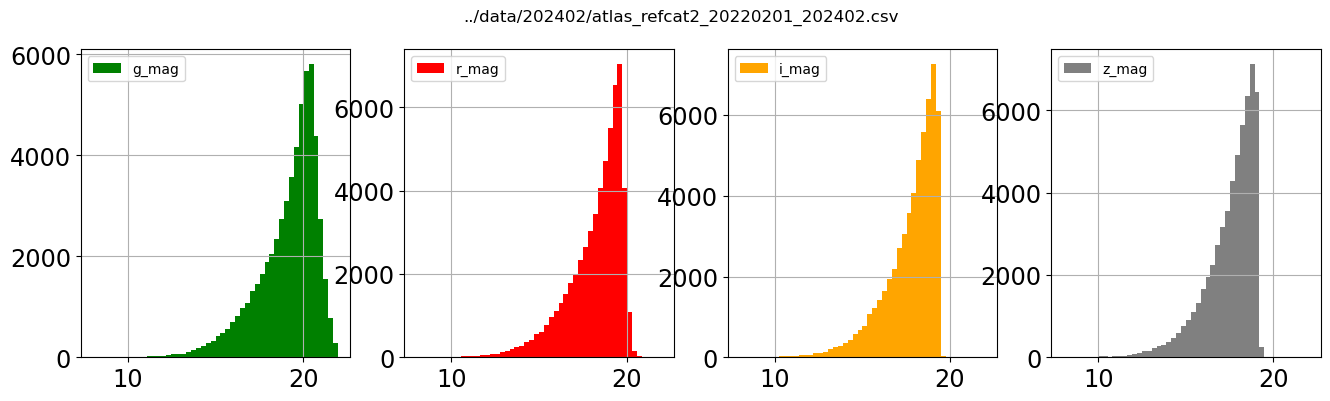

In [17]:
variable_names = ["g_mag","r_mag","i_mag","z_mag"]
all_bands = ["g","r","i","z"]
all_band_colors = ["g","r","orange","grey"]
NB = len(all_bands)

fig,axs  = plt.subplots(nrows=1,ncols=NB,figsize=(16,4))

for iband in range(NB):
    name = variable_names[iband]
    df[name].hist(bins=50,range=(8,22),ax=axs[iband],facecolor=all_band_colors[iband],legend=True)
    #ax.legend()
plt.suptitle(filesource_in)

In [18]:
cmap = matplotlib.cm.inferno
cmap_reversed = matplotlib.cm.get_cmap('inferno_r')


/tmp/ipykernel_6858/2908131000.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_reversed = matplotlib.cm.get_cmap('inferno_r')


In [19]:
xvals = [RAMIN,RAMAX,RAMAX,RAMIN,RAMIN]
yvals = [DECMIN,DECMIN,DECMAX,DECMAX,DECMIN]

/tmp/ipykernel_6858/2251194231.py:9: UserWarning: 'color' and 'colormap' cannot be used simultaneously. Using 'color'
  im = df_cut.plot.scatter('ra','dec',ax=ax,marker='o',color=my_colors,cmap="jet_r")


Text(0.5, 1.0, 'catalog sources m_I<12 mag in tract 3864')

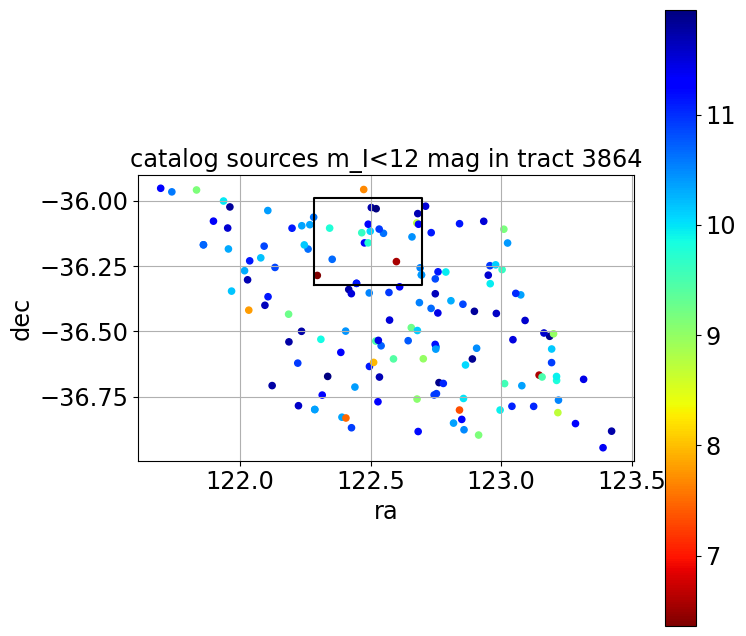

In [20]:
MAGCUT = 12

cut = (df[variable_names[0] ] < MAGCUT)  & (df[variable_names[1] ] < MAGCUT) & (df[variable_names[2] ] < MAGCUT) & (df[variable_names[0] ] < MAGCUT)

df_cut = df[cut]
my_colors = df_cut["i_mag"].values
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(8,8))

im = df_cut.plot.scatter('ra','dec',ax=ax,marker='o',color=my_colors,cmap="jet_r")
ax.plot(xvals,yvals,color='k')
ax.grid()

#cbar = plt.colorbar(ax.collections[0], ax=ax)
plt.gca().set_aspect('equal')
title = f"catalog sources m_I<{MAGCUT} mag in tract {TRACT_SEL}"
plt.title(title)